# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:


**Ожидаемая оценка:** 6.1

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [6]:
X = data
y = target

In [7]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [9]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.03606015556646

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [12]:
import random

In [14]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    n = y.shape[0]
    error = np.zeros(n)
    avarage_pred = np.zeros(n)
    avarage_2_pred = np.zeros(n)
    appears = np.zeros(n)

    for _ in range(num_runs):
        idx_bootstraped = np.random.choice(n, size=n)
        regressor.fit(X[idx_bootstraped], y[idx_bootstraped])
        out_of_bag = list(set(np.arange(n)) - set(idx_bootstraped))

        avarage_pred[out_of_bag] += regressor.predict(X[out_of_bag])
        avarage_2_pred[out_of_bag] += regressor.predict(X[out_of_bag]) ** 2

        error[out_of_bag] += (regressor.predict(X[out_of_bag]) - y[out_of_bag]) ** 2
        appears[out_of_bag] += 1

    bias = ((avarage_pred / appears - y) ** 2).mean()
    var = (avarage_2_pred / appears - (avarage_pred / appears) ** 2).mean()
    error = (error / appears).mean()

    return bias, var, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [16]:
models = {
    "Linreg": LinearRegression(),
    "DecTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor()
}

for name, model in models.items():
    bias, var, error  = compute_biase_variance(model, X, y)
    print(f'Model: {name} Bias: {bias}, Variance: {var}, Error: {error}')

Model: Linreg Bias: 23.7323608391863, Variance: 1.276798463133035, Error: 25.009159302319322
Model: DecTree Bias: 10.320821425199803, Variance: 13.761376114018084, Error: 24.082197539218036
Model: RandomForest Bias: 11.286226158133182, Variance: 2.485802199273375, Error: 13.772028357406533


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

 * **Линениная регрессия:**

  Высокий `bias` и низкий `variance` (линейные модели нечувствительны к изменениям в обучающей выборке, рассматриваются только линейнаые зависимости).

* **Решающее дерево:**
 Низкий `bias` и высокий `variance` (подстраиваются под обучающую выборку, соответвенно чувствительны к изменениям в ней, вычисляютcя более сложные зависимости).

* **Случайный лес:**  
  Низкий `bias`, низкий `variance`, низкий `error` (случайный лес не так сильно подстраивается под обучающую выборку, сохраняя `bias` как решающего дерева, а `variance` понизился, т.к случайный лес в каждой вершине выбирает рандомный набор признаков).

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [17]:
from sklearn.ensemble import BaggingRegressor

In [18]:
for name, model in models.items():
    bias, var, error  = compute_biase_variance(BaggingRegressor(model, n_estimators=10), X, y)
    print(f'Bagged Model: {name} Bias: {bias}, Variance: {var}, Error: {error}')

Bagged Model: Linreg Bias: 23.73043928917604, Variance: 1.4039703265899264, Error: 25.134409615765943
Bagged Model: DecTree Bias: 11.171856489121403, Variance: 3.719656025343846, Error: 14.891512514465223
Bagged Model: RandomForest Bias: 12.32845607115931, Variance: 1.5864721820997685, Error: 13.914928253259145



Сохранил результат в случае перезапуска:
```
Bagged Model: Linreg Bias: 23.73043928917604, Variance: 1.4039703265899264, Error: 25.134409615765943
Bagged Model: DecTree Bias: 11.171856489121403, Variance: 3.719656025343846, Error: 14.891512514465223
Bagged Model: RandomForest Bias: 12.32845607115931, Variance: 1.5864721820997685, Error: 13.914928253259145
```

Теоритически беггинг не меняет смещение и уменьшает разброс в n раз (при некоррелированых моделях)


* **Линениная регрессия:**

  Изменений практически нет, т.к. кореллированы.

* **Решающее дерево:**
 Cмещение не поменялись, разброс сильно уменьшился, error уменьшился. Если бы модели были некоррелированы то разрос бы уменьшился в 10 раз, но т.к. модели слабо коррелированы, то значение умениньшилось в 3.7 раза.

* **Случайный лес:**  
  Значения примерно прежние.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [36]:
import seaborn as sns

In [40]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    idxs_test = np.random.choice(X.shape[0], size=num_test_objects)
    idxs_train = list(set(np.arange(X.shape[0])) - set(idxs_test))

    X_train, y_train = X[idxs_train], y[idxs_train]
    X_test, y_test = X[idxs_test], y[idxs_test]

    x = np.arange(num_test_objects)
    for _ in range(num_runs):
        idxs_current = np.random.choice(X_train.shape[0], size=X_train.shape[0])

        regressor.fit(X_train[idxs_current], y_train[idxs_current])
        pred = regressor.predict(X_test)

        sns.scatterplot(x=x, y=pred, color="blue")

    sns.scatterplot(x=x, y=y_test, color="red", label="Real answer")
    plt.xlabel("Test objects")
    plt.ylabel("Predictions")
    plt.title(title)
    plt.legend()


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

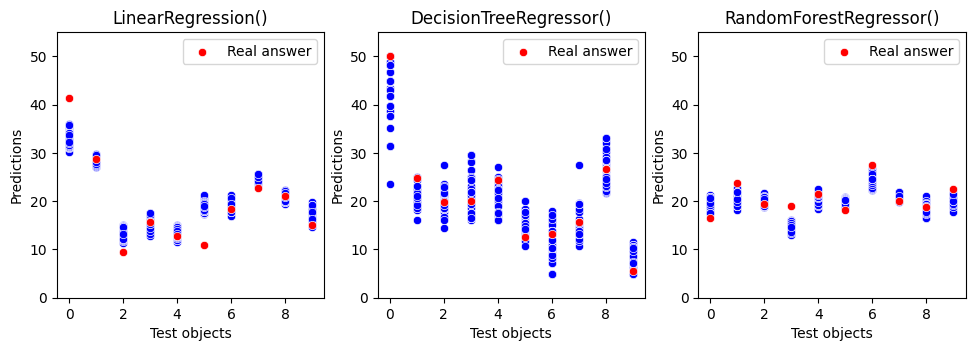

In [45]:
plt.figure(figsize=(20, 20))
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

for i in range(len(models)):
    plt.subplot(5, 5, i + 1)
    plot_predictions(models[i], X, y, title=models[i])
    plt.ylim([0, 55])
plt.show()

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__


* **Линениная регрессия:**

  Как мы видим предсказания находятся рядом друг с другом, что соответсвует низкому разбросу. Но устредненные предсказания находятся далеко от правильных ответов, что соответсвует высокому смещению. Подтвердили теоритические и эмпирические знания.

* **Решающее дерево:**
  Большие расстояния между предсказаниями соответсвуют высокому разбросу. Устредненные предсказания находятся недалеко от правильных ответов, что соответсвует низкому смещению. Еще раз подтвердили теоритические и эмпирические знания

* **Случайный лес:**  
  Как мы видим предсказания находятся рядом друг с другом, что соответсвует низкому разбросу. Устредненные предсказания находятся недалеко от правильных ответов (сгруппированы рядом), что соответсвует низкому смещению. В очередной раз подтвердили теоритические и эмпирические знания

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

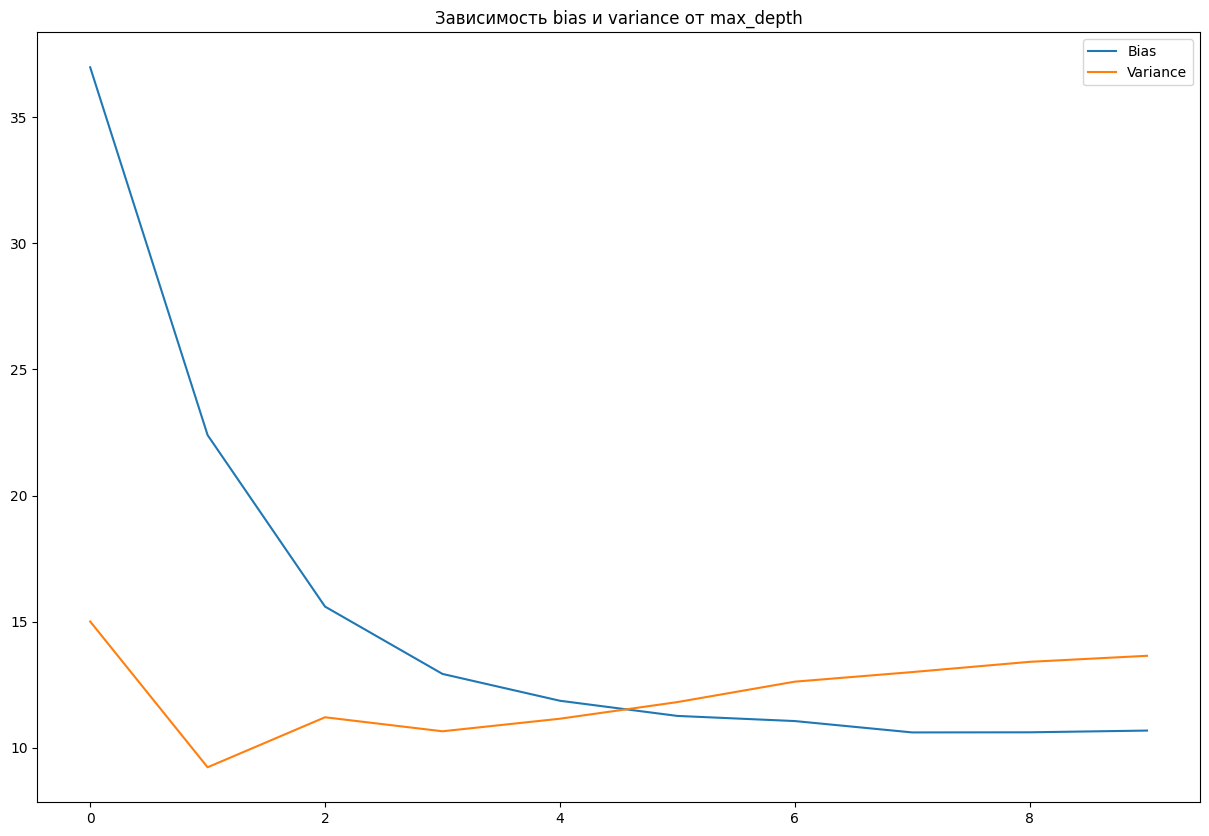

In [49]:
variances = []
biases = []

for i in range(1, 11):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=i), X, y)
    variances.append(variance)
    biases.append(bias)

plt.subplots(figsize=(15, 10))
plt.plot(biases, label="Bias")
plt.plot(variances, label="Variance")
plt.title("Зависимость bias и variance от max_depth")
plt.legend()

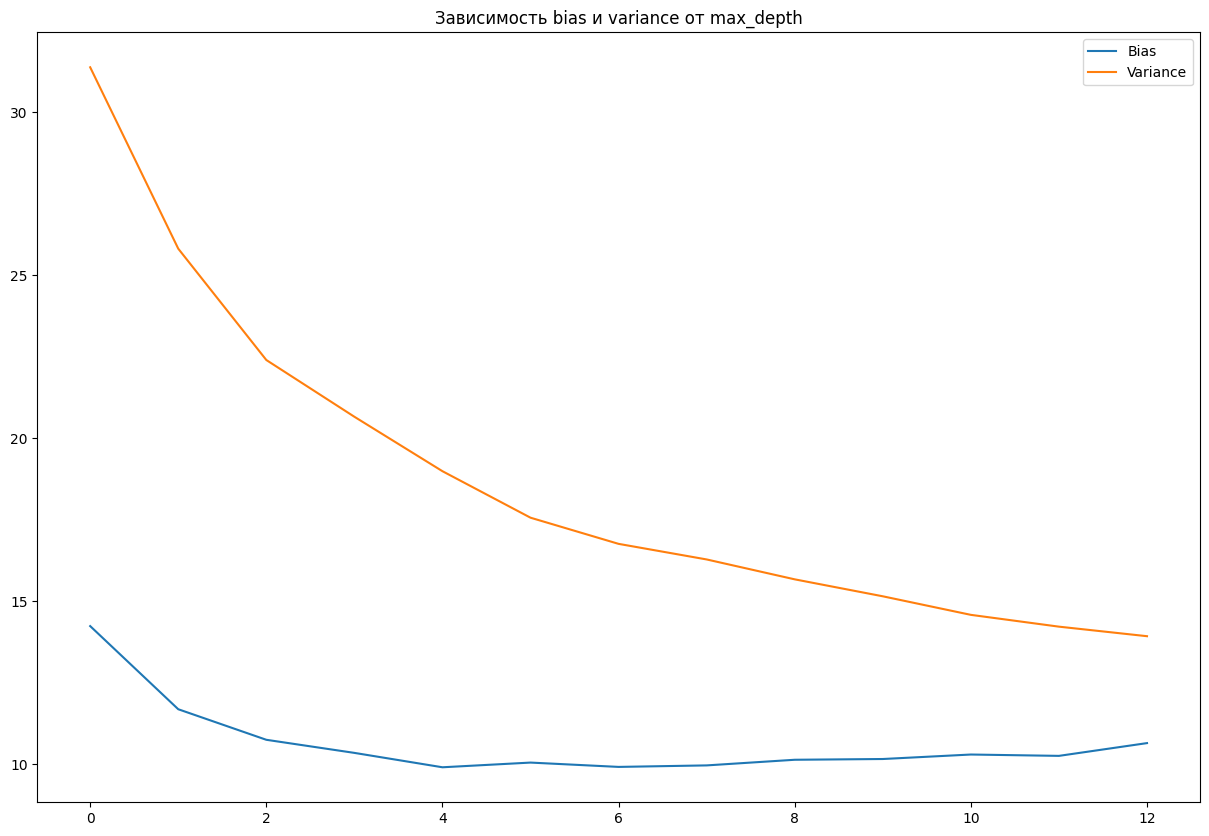

In [50]:
variances = []
biases = []

for i in range(1, X.shape[1] + 1):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_features=i), X, y)
    biases.append(bias)
    variances.append(variance)

plt.subplots(figsize=(15, 10))
plt.plot(biases, label="Bias")
plt.plot(variances, label="Variance")
plt.title("Зависимость bias и variance от max_features")
plt.legend()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
n_estimators_values = 2**np.arange(1, 10)

variances = []
biases = []

for n_estimators in n_estimators_values:
    bias, variance, _ = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimators), X, y)
    biases.append(bias)
    variances.append(variance)

plt.subplots(figsize=(15, 10))
plt.plot(biases, label="Bias")
plt.plot(variances, label="Variance")
plt.title("Зависимость bias и variance от n_estimators в RandomForest")
plt.legend()

In [ ]:
variances = []
biases = []

for n_estimators in n_estimators_values:
    bias, variance, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimators), X, y)
    biases.append(bias)
    variances.append(variance)

plt.subplots(figsize=(15, 10))
plt.plot(biases, label="Bias")
plt.plot(variances, label="Variance")
plt.title("Зависимость bias и variance от n_estimators в GradientBoosting")
plt.legend()

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

1. Видим что смещение монотонно убывает с ростом максимальной глубины дерева. Т.к увелечение глубины увеличивает силу модели и позволяет ей выдвать более правильные ответы. Но в то же время можем увидеть что, разброс в какой-то момент начинает расти, т.к. модель подстраиваясь под тестовые данные, начинает выдавать более разнообразные выходы для входных данных, то есть становится более зависима от входных данных, что соответвует увеличению разброса.
2. Видим что оба показателя убывают при увеличении кол-ва признаков, т.к. увеличивая их кол-во мы можем позволить модели более точно определять выход и уменьшает разброс т.к. раньше модель основывалась на меньшем кол-ве признаков и могла выдвавать различные выводы при небольшом изменении данных.


Остальные графики не успели отобразиться после перезагрузки.

3. В графике зависимости от n в Random Forest, смещение не должно меняться, а разброс должен уменьшаться, по свойствам случ леса

4. В графике зависимости от n в бустинге, смещение должно падать, а разброс должен находиться на одном уровне.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

Как то так...

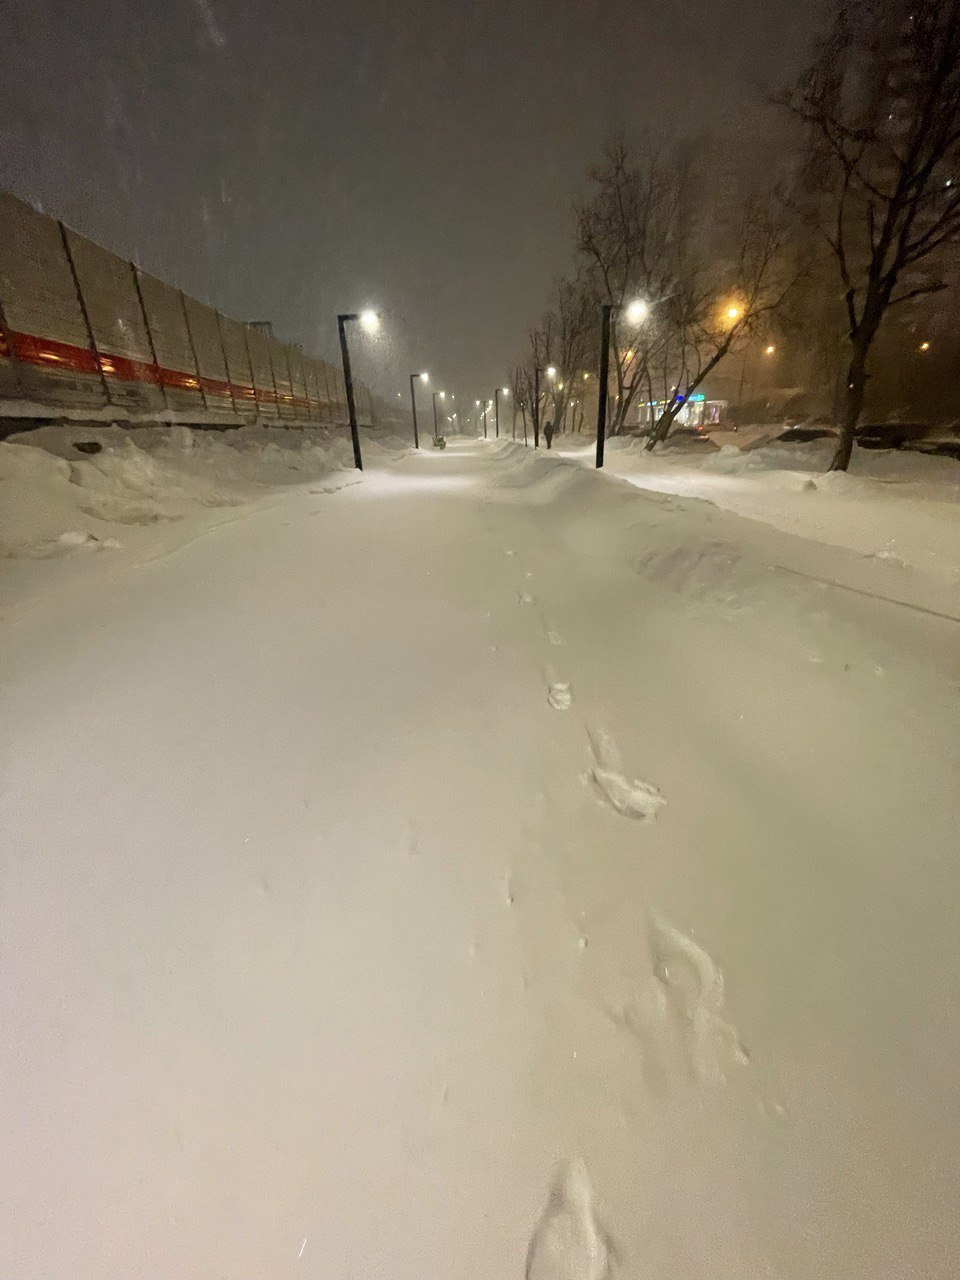